In [8]:

from xbbg import blp
import scipy.interpolate as interp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pysabr
from statistics import NormalDist
import seaborn as sns
import math

import datetime
from dateutil.relativedelta import relativedelta



In [9]:
def fwd_outright(ccy, tenor, driver = None):
    # Derive the forward outright from the spot price, and the forward points
    spot = (blp.bdp(ccy+"Curncy", "LAST_PRICE"))["last_price"][0]    # Bloomberg API call
    if not driver:
        points = (blp.bdp(ccy+tenor+"Curncy", "LAST_PRICE"))["last_price"][0]
    else:
        try:
            points = (blp.bdp(driver+tenor+"Curncy", "LAST_PRICE"))["last_price"][0]
        except:
            points = 0
    decimal = str(spot)[::-1].find('.')    # Points are quoted as they would be verbally, so we need to rescale to the correct decimal
    fwd = spot + points/(10**decimal)
    return fwd

In [10]:
def strike_from_vol(fwd, delta, vol, t_years):
    # Invert Black-Scholes to derive option strike from a vol, delta, forward, and time to maturity
    strike = fwd*math.exp(-1*NormalDist().inv_cdf(delta)*vol*math.sqrt(t_years)-0.5*(vol**2)*t_years)
    return strike

In [11]:
def smile_vols(ccy, tenor, t_years, driver = None):
    # Pull 5-point vol smile for a given currency and tenor.
    fwd = fwd_outright(ccy, tenor, driver)
    # API call to get vol, RR, fly
    vol = blp.bdp(ccy + "V" + tenor + "Curncy", "LAST_PRICE")['last_price'][0]*.01
    rr25 = blp.bdp(ccy + "25R" + tenor + "Curncy", "LAST_PRICE")['last_price'][0]*.01
    rr10 = blp.bdp(ccy + "10R" + tenor + "Curncy", "LAST PRICE")['last_price'][0]*.01
    f25 = blp.bdp(ccy + "25B" + tenor + "Curncy", "LAST_PRICE")['last_price'][0]*.01
    f10 = blp.bdp(ccy + "10B" + tenor + "Curncy", "LAST_PRICE")['last_price'][0]*.01
    
    # Calculate outright vols
    c25 = vol + 0.5*rr25 + f25
    p25 = vol - 0.5*rr25 + f25
    c10 = vol + 0.5*rr10 + f10
    p10 = vol -0.5*rr10 + f10
    
    # Create DataFrame with vols, deltas, absolute strikes, and log-moneyness
    vols = [p10, p25, vol, c25, c10]
    deltas = [0.90, 0.75, 0.50, 0.25, 0.10]
    smile = pd.DataFrame({"Vols" : vols, "Delta" : deltas})
    strikes = []
    for index in smile.index:
        strikes.append(strike_from_vol(fwd = fwd, delta = smile["Delta"][index], vol = smile["Vols"][index], t_years = t_years))
    smile["Strikes"] = strikes
    smile["Vols_Scaled"]=smile["Vols"]*100
    smile["Log_Moneyness"]=1+np.log(smile["Strikes"]/fwd)
    
    return smile

In [12]:
def prob(smile, delta_range, fwd, t_years):
    probs = []
    for i in range(0, len(smile)):
        vol = smile[i]
        k = delta_range[i]
        d2 = (1/(vol*np.sqrt(t_years)))*(np.log(fwd/k)+0.5*t_years*vol**2)
        p = 1-NormalDist().cdf(x = d2)
        probs.append(p)
    data = {"CDF": probs, "Strikes": delta_range}
    df = pd.DataFrame(data = data)
    plt.figure(figsize = (8,8))
    sns.lineplot(x = "Strikes", y = "CDF", data = df, color = "blue")
    plt.xticks(rotation = 45)
    return df

In [13]:
def sabr_fit_plot(ccy, tenor, t_years, smile, params):
    fwd = smile["Log_Moneyness"][2]
    dn = smile["Vols"][2]
    
    # API call for realized volatility
    dn_realized = blp.bdp(ccy+"H"+tenor+"Curncy", "last price")["last_price"][0]/100
    
    # SABR initialization
    sabr = pysabr.Hagan2002NormalSABR(f = fwd, shift = 0, t=t_years, v_atm_n = dn, beta = 0, 
                                      rho = params["rho_mkt"], volvol = params["volvol_mkt"])
    sabr_rlz = pysabr.Hagan2002NormalSABR(f = fwd, shift = 0, t=t_years, v_atm_n = dn_realized, beta = 0, 
                                          rho = params["rho_real"], volvol = params["volvol_real"])
    sabr_rlz_surf = pysabr.Hagan2002NormalSABR(f = fwd, shift = 0, t=t_years, v_atm_n = dn, beta = 0,  
                                               rho = params["rho_real"], volvol = params["volvol_real"])
    
    # Cubic smile interpolation of market vols (5 points)
    mkt_smile_interp = interp.interp1d(smile.Log_Moneyness, smile.Vols, kind = "cubic")
    
    # Interpolate 25 strikes
    step = (smile["Log_Moneyness"][4]-smile["Log_Moneyness"][0])/25
    delta_range=np.arange(smile["Log_Moneyness"][0]*1.0001,smile["Log_Moneyness"][4]*0.9999,step)
    ynew=mkt_smile_interp(delta_range)
    
    # Fit SABR to expanded strike range
    sabr_mkt_refit=[]
    sabr_rlz_refit=[]
    sabr_rlz_surf_refit=[]
    
    for i in delta_range:
        sabr_mkt_refit.append(sabr.normal_vol(i))
        sabr_rlz_refit.append(sabr_rlz.normal_vol(i))
        sabr_rlz_surf_refit.append(sabr_rlz_surf.normal_vol(i))
    
    # Derive Probabilities
    
    cdf = prob(sabr_rlz_refit, delta_range, fwd, t_years)
    
    
    # Scale to 100 for better visual interpretation
    ynew_scaled = [100*i for i in ynew]
    sabr_mkt_refit_scaled = [100*i for i in sabr_mkt_refit]
    sabr_rlz_refit_scaled = [100*i for i in sabr_rlz_refit]
    sabr_rlz_surf_refit_scaled = [100*i for i in sabr_rlz_surf_refit]
    
    smile["SABR_Implied"] = smile["Log_Moneyness"].apply(lambda x: sabr.normal_vol(x)*100)
    smile["SABR_Realized"] = smile["Log_Moneyness"].apply(lambda x: sabr_rlz.normal_vol(x)*100)
    
    # Plots
    plt.figure(figsize=(16,16))
    plt.gca().set_facecolor("white")
    plt.subplot(2,2,1)
    plt.plot(delta_range, ynew_scaled, 'red', label = "Current Market")
    plt.plot(delta_range, sabr_mkt_refit_scaled, 'blue', 
             label = "SABR Market Fit: rho %.4f, volvol %.4f"%(params["rho_mkt"], params["volvol_mkt"]))
    plt.plot(delta_range, sabr_rlz_refit_scaled, 'green', 
             label = "Realized Smile: rho %.4f, volvol %.4f"%(params["rho_real"], params["volvol_real"]))
    plt.plot(delta_range, sabr_rlz_surf_refit_scaled, 'orange', 
             label = "Implied Vol, Realized RR/Fly: rho %.4f, volvol %.4f"%(params["rho_real"], params["volvol_real"]))
    plt.legend()
    plt.title("%s %s SABR Fit, Implied/Realized"%(ccy, tenor))
    plt.xlabel("Log-Moneyness (10D Put to 10D Call)")
    plt.ylabel("Vol")
    plt.subplot(2,2,2)
    
    # SABR smile differentials
    sabr_diff=[]
    sabr_fixvol_diff=[]
    for x in range(0, len(sabr_mkt_refit)):
        sabr_diff.append(sabr_mkt_refit_scaled[x]-sabr_rlz_refit_scaled[x])
        sabr_fixvol_diff.append(sabr_mkt_refit_scaled[x]-sabr_rlz_surf_refit_scaled[x])
    plt.plot(delta_range, sabr_diff, 'cyan', label = "Implied Surface-Realized Vol + Surface")
    plt.plot(delta_range, sabr_fixvol_diff, 'teal', label = "Implied Surface-Realized Surface Only")
    plt.legend()
    plt.xlabel("Log-Moneyness (10D Put to 10D Call)")
    plt.ylabel("Vol Difference")
    plt.title("%s %s Implied-Realized Surface Comparison"%(ccy, tenor))
    plt.show()


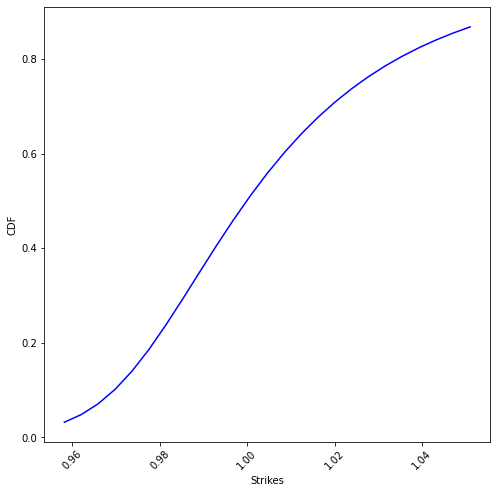

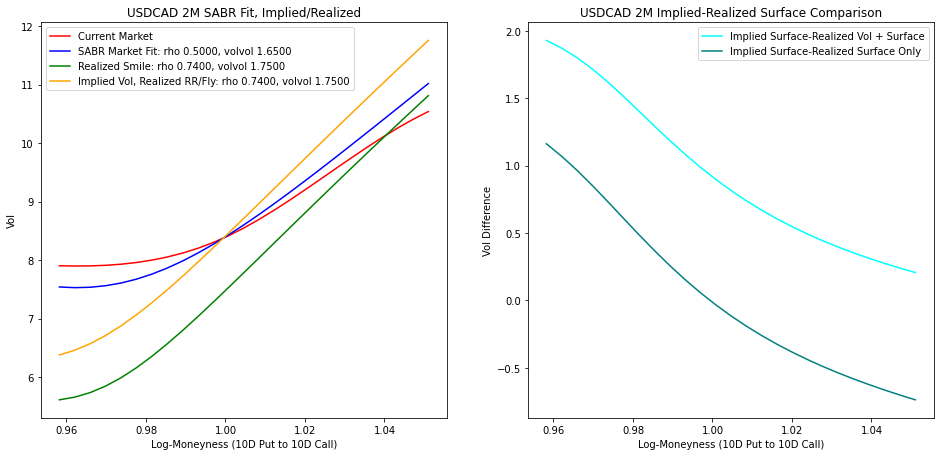

In [14]:

parameters = {"rho_mkt": 0.5, "volvol_mkt": 1.65, "rho_real": 0.74, "volvol_real": 1.75}
(sabr_fit_plot(ccy = "USDCAD", tenor = "2M", t_years = 2/12, 
                    smile = smile_vols(ccy = "USDCAD", tenor = '2M', t_years = 2/12), params = parameters))

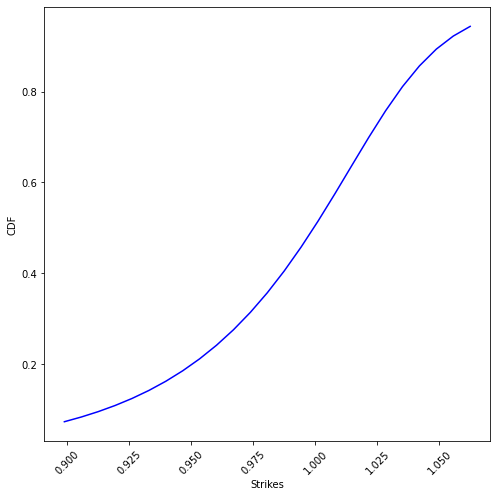

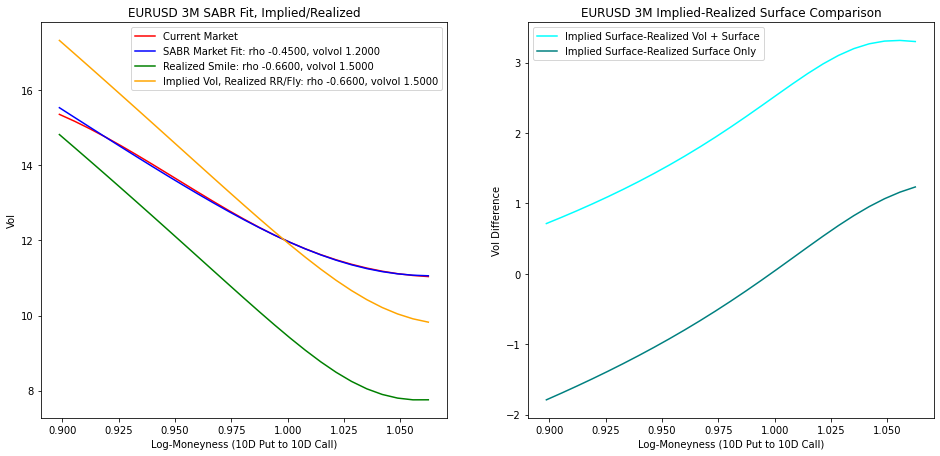

In [37]:
parameters = {"rho_mkt": -0.45, "volvol_mkt": 1.2, "rho_real": -0.66, "volvol_real": 1.5}
(sabr_fit_plot(ccy = "EURUSD", tenor = "3M", t_years = 3/12, 
                    smile = smile_vols(ccy = "EURUSD", tenor = '3M', t_years = 3/12), params = parameters))

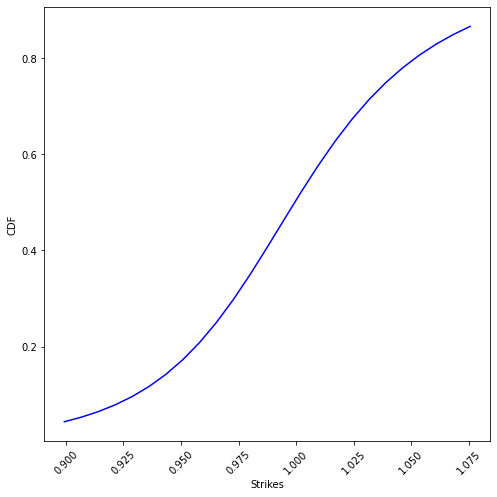

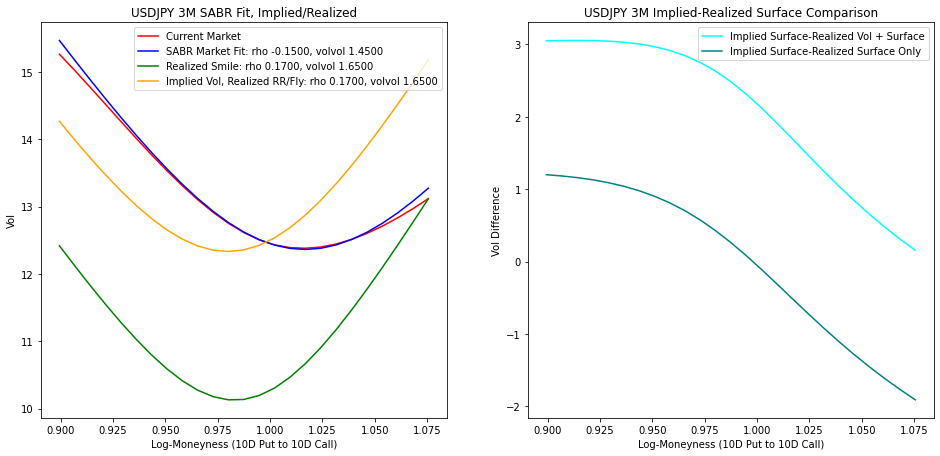

In [36]:
parameters = {"rho_mkt": -0.15, "volvol_mkt": 1.45, "rho_real": 0.17, "volvol_real": 1.65}
(sabr_fit_plot(ccy = "USDJPY", tenor = "3M", t_years = 3/12, 
                    smile = smile_vols(ccy = "USDJPY", tenor = '3M', t_years = 3/12), params = parameters))

       Vols  Delta   Strikes  Vols_Scaled  Log_Moneyness  SABR_Implied  \
0  0.099675   0.90  0.936103      9.96750       0.934889     10.186033   
1  0.086038   0.75  0.969611      8.60375       0.970059      8.635912   
2  0.076550   0.50  0.998350      7.65500       0.999268      7.655000   
3  0.074213   0.25  1.023697      7.42125       1.024339      7.395361   
4  0.077425   0.10  1.049112      7.74250       1.048863      7.747775   

   SABR_Realized  
0      11.511521  
1       9.662054  
2       8.485300  
3       8.205341  
4       8.677842  


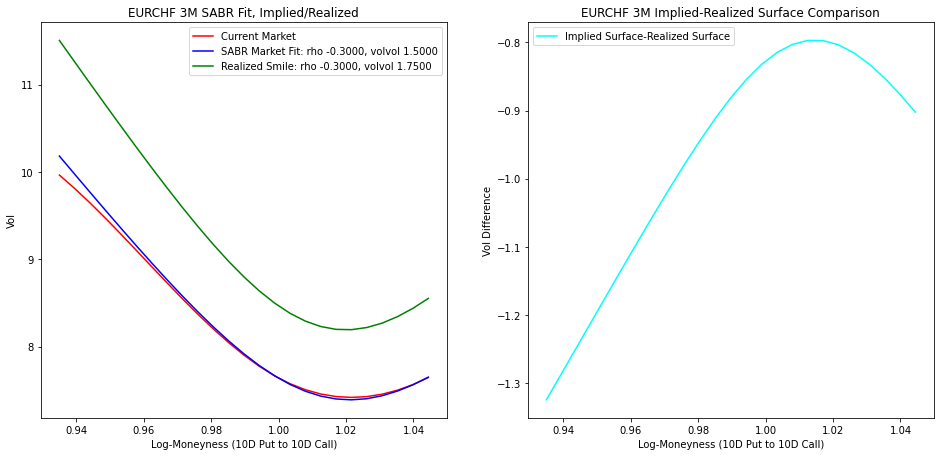

In [42]:
parameters = {"rho_mkt": -0.3, "volvol_mkt": 1.50, "rho_real": -0.3, "volvol_real": 1.75}
(sabr_fit_plot(ccy = "EURCHF", tenor = "3M", t_years = 3/12, 
                    smile = smile_vols(ccy = "EURCHF", tenor = '3M', t_years = 3/12), params = parameters))

      Vols  Delta   Strikes  Vols_Scaled  Log_Moneyness  SABR_Implied  \
0  0.17295   0.90  0.609249       17.295       0.885439     17.631806   
1  0.14955   0.75  0.647784       14.955       0.946769     15.027989   
2  0.13175   0.50  0.681719       13.175       0.997830     13.175000   
3  0.12505   0.25  0.711237       12.505       1.040218     12.302594   
4  0.12355   0.10  0.738076       12.355       1.077260     12.297452   

   SABR_Realized  
0      18.705984  
1      15.713617  
2      13.220200  
3      11.434405  
4      10.559683  


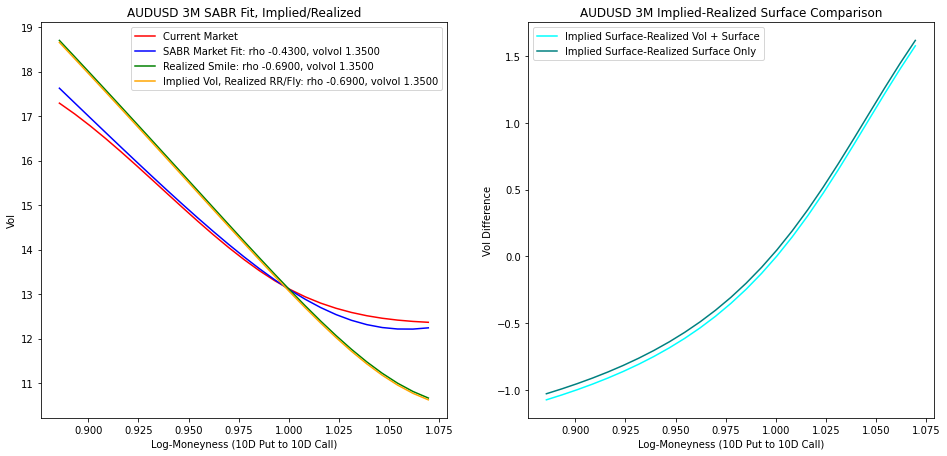

In [84]:
parameters = {"rho_mkt": -0.43, "volvol_mkt": 1.35, "rho_real": -0.69, "volvol_real": 1.35}
(sabr_fit_plot(ccy = "AUDUSD", tenor = "3M", t_years = 3/12, 
                    smile = smile_vols(ccy = "AUDUSD", tenor = '3M', t_years = 3/12), params = parameters))

In [31]:
def hist_data(tickers, start_date, end_date, condition):
    # Return a matrix of prices, with modifiable pricing condition
    data = blp.bdh(tickers, condition, start_date,end_date)
    data = data.dropna()
    col_clean = []
    for col in data.columns:
        col_clean.append(col[0])
    data.columns = col_clean
    return data


In [32]:
def spot_vol_corr(ccyvol, lookback_days = 90):
    data = hist_data(tickers = ccyvol, start_date = datetime.date.today()+ relativedelta(days = -1 * lookback_days),
                    end_date = datetime.date.today(), condition = "PX_CLOSE_1D")
    data = data.diff()
    data.dropna(inplace = True)
    ax = sns.heatmap(data.corr(), annot = True, cmap = 'flare')
    ax.set(xlabel = None)
    ax.set(ylabel = None)

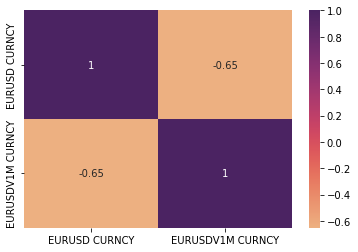

In [33]:
spot_vol_corr(["EURUSD CURNCY", "EURUSDV1M CURNCY"])

In [22]:
def kurtosis(pair, lookback_days = 90):
    data = hist_data(tickers = pair, start_date = datetime.date.today()+ relativedelta(days = -1 * lookback_days),
                    end_date = datetime.date.today(), condition = "PX_CLOSE_1D")
    data = data.apply(lambda x: np.log(x))
    data = data.diff()
    data.dropna(inplace = True)
    kurt = np.exp(data.kurtosis())
    return kurt

In [193]:
print(kurtosis("USDJPY CURNCY"))

USDJPY CURNCY    1.592138
dtype: float64
